In [1]:
import os
from torch import optim, nn, utils, Tensor
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import lightning as L

/home/sirius/PhD/miniconda3/envs/dl/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Pytrorch Lightening 

L.LightningModule + Trainer

In [4]:
# define any number of nn.Modules (or use your current ones)
encoder = nn.Sequential(nn.Linear(28 * 28, 64), nn.ReLU(), nn.Linear(64, 3))
decoder = nn.Sequential(nn.Linear(3, 64), nn.ReLU(), nn.Linear(64, 28 * 28))


# define the LightningModule
class LitAutoEncoder(L.LightningModule):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.redundant_linear = nn.Linear(3, 3)

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x, _ = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = nn.functional.mse_loss(x_hat, x)
        # Logging to TensorBoard (if installed) by default
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


# init the autoencoder
autoencoder = LitAutoEncoder(encoder, decoder)

In [5]:
# check autoendocer parameters
print(autoencoder)

LitAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=784, bias=True)
  )
  (redundant_linear): Linear(in_features=3, out_features=3, bias=True)
)


In [ ]:
# setup data
dataset = MNIST(os.getcwd(), download=True, transform=ToTensor())
train_loader = utils.data.DataLoader(dataset)

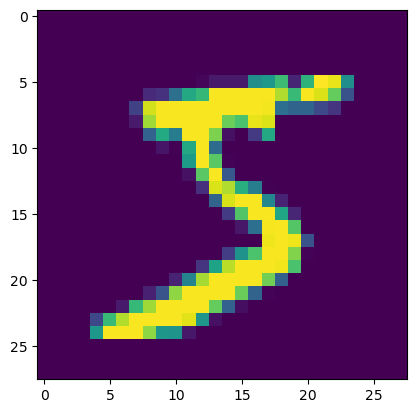

In [12]:
# plot dataset 0
import matplotlib.pyplot as plt
plt.imshow(dataset[0][0].squeeze())
plt.show()

In [14]:
# train the model (hint: here are some helpful Trainer arguments for rapid idea iteration)
trainer = L.Trainer(limit_train_batches=1000, max_epochs=10)
trainer.fit(model=autoencoder, train_dataloaders=train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type       | Params | Mode 
--------------------------------------------------------
0 | encoder          | Sequential | 50.4 K | train
1 | decoder          | Sequential | 51.2 K | train
2 | redundant_linear | Linear     | 12     | train
--------------------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.407     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1000/1000 [00:01<00:00, 649.67it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1000/1000 [00:01<00:00, 647.73it/s, v_num=1]


In [16]:
# load checkpoint
import torch
checkpoint = "./lightning_logs/version_0/checkpoints/epoch=0-step=100.ckpt"
autoencoder = LitAutoEncoder.load_from_checkpoint(checkpoint, encoder=encoder, decoder=decoder)

# choose your trained nn.Module
encoder = autoencoder.encoder
encoder.eval()

# embed 4 fake images!
fake_image_batch = torch.rand(4, 28 * 28, device=autoencoder.device)
embeddings = encoder(fake_image_batch)
print("⚡" * 20, "\nPredictions (4 image embeddings):\n", embeddings, "\n", "⚡" * 20)

⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡ 
Predictions (4 image embeddings):
 tensor([[ 0.4607, -0.1376,  0.4699],
        [ 0.5582, -0.2445,  0.4261],
        [ 0.4035, -0.1665,  0.4141],
        [ 0.4376, -0.1511,  0.3795]], device='cuda:0',
       grad_fn=<AddmmBackward0>) 
 ⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡
